# Efficient Frontier #

Industry_Portfolios.xlsx contains monthly nominal (net) returns for ten industry portfolios (expressed as percentages, but without "%"), over the ten-year period from Jan 2004 through Dec 2013.

Use these returns to estimate the vector of mean returns and the covariance matrix of returns for the ten industry portfolios:
* Create a table showing the mean return and standard deviation of return for the ten industry portfolios.
* Plot the minimum-variance frontier (without the riskless asset) generated by the ten industry portfolios.
* This graph must have expected (monthly) return on the vertical axis vs standard deviation of (monthly) return on the horizontal axis.
* This graph must cover the range from 0% to 2% on the vertical axis, in increments of 0.1% (or less).
* Briefly explain the economic significance and relevance of the minimum-variance frontier to an investor.

Now suppose that the (net) risk-free rate is 0.13% per month:
* Plot the efficient frontier (with the riskless asset) on the same graph as the minimum-variance frontier generated by the ten industry portfolios.
* Briefly explain the economic significance and relevance of the efficient frontier to an investor.

The two frontiers will intersect at single point: the tangency portfolio:
* Calculate the Sharpe ratio for the tangency portfolio, and also the tangency portfolio weights for the ten industry portfolios.
* Briefly explain the economic significance and relevance of the tangency 
portfolio to an investor.
Economic significance:

Minimum-variance frontier represents outermost envelope of attainable portfolios ⇒ no attainable portfolio exists on the left of the minimum-variance frontier.

Efficient frontier consists of portfolios with highest potential reward for given amount of risk ⇒ risk-averse investor must invest in (optimal) portfolio on efficient frontier to maximise expected utility.

Tangency portfolio has the highest possible Sharpe ratio.

In [1]:
import numpy as np
import scipy as sp
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
rawdata = pd.read_excel("Industry_Portfolios.xlsx")
workdata = rawdata.drop(["Date"], axis=1)

c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
R = workdata.mean().to_numpy()
V = workdata.cov().to_numpy()
stdev = workdata.std()

In [4]:
resultdf = pd.DataFrame([workdata.mean(), workdata.std()]).T.rename(
    columns={0: "mean", 1: "std dev"}
)
resultdf

,mean,std dev
NoDur,0.902833,3.345657
Durbl,0.733333,8.361852
Manuf,1.012833,5.310270
Enrgy,1.231167,6.081524
HiTec,0.766250,5.381191
Telcm,0.881417,4.448284
Shops,0.916333,4.093786
Hlth,0.783833,3.787172
Utils,0.907167,3.701763
Other,0.489083,5.582452


Variance of return for frontier portfolio:
$$
\sigma_{p}^2 = \frac{1}{\delta} + \frac{\delta}{\zeta \delta - \alpha^2} {(R_p - R_{mv})}^2
$$
$$
\alpha = \textbf{R'}\textbf{V}^{-1}\textbf{e}\\
\zeta = \textbf{R'}\textbf{V}^{-1}\textbf{R}\\
\delta = \textbf{e'}\textbf{V}^{-1}\textbf{e}\\
$$


Where
* $\textbf{R}$ : n × 1 vector of expected returns
* $\textbf{V}$ : n × n covariance matrix of returns, which consists of
variances on diagonal and covariances on off-diagonal
* $\textbf{w}$ : n × 1 vector of portfolio weights,
which represents proportion of investor’s wealth allocated to
each tradable financial asset
* $R_p$ is return of portfolio, where $\textbf{w'}\textbf{R}= R_P$
* $R_{mv}$ is mean return for global minimum-variance portfolio $(\frac{a}{b})$


In [5]:
class mva:
    def __init__(self, R, V):
        self.R = R  # mean
        self.V = V  # covariance matrix
        self.size = len(self.R)
        self.V_inv = np.linalg.inv(self.V)

        # params straight away call the inst var
        self.alpha = np.dot(np.dot(self.R.T, self.V_inv), np.ones(self.size))
        self.zeta = np.dot(np.dot(self.R.T, self.V_inv), self.R)
        self.delta = np.dot(np.dot(np.ones(self.size), self.V_inv), np.ones(self.size))
        self.R_mv = self.alpha / self.delta

    def var_mva(self, R_p):
        """
        this is for plotting the parabola-shaped frontier
        THIS IS VARIANCE, NEED TO SQRT THE OUTPUT, refer to plot
        """
        return (1 / self.delta) + (R_p - self.R_mv) ** 2 * (
            self.delta / (self.zeta * self.delta - self.alpha**2)
        )

    def var_mva_with_riskfree(self, R_p, rf):
        """
        this is the straight line frontier
        THIS IS VARIANCE, NEED TO SQRT THE OUTPUT, refer to plot
        """
        return ((R_p - rf) ** 2) / (
            self.zeta - 2 * self.alpha * rf + self.delta * rf**2
        )

    def weights_calc(self, R_p):
        """
        for a given R_p, return the risk-minimized portfolio weights
        """
        _multiplier_1 = (self.delta * R_p - self.alpha) / (
            self.zeta * self.delta - self.alpha**2
        )
        _multiplier_2 = (self.zeta - self.alpha * R_p) / (
            self.zeta * self.delta - self.alpha**2
        )
        return _multiplier_1 * (np.dot(self.V_inv, R)) + _multiplier_2 * (
            np.dot(self.V_inv, np.ones(self.size))
        )

    def tangent_portfolio(self, R_p_list, rf):
        """
        returns information about tangent portfolio
            1. tangent return
            2. var & std dev of return
            3. sharpe ratio at tangent
            4. tangent portfolio weight
        """
        R_tg = (self.alpha * rf - self.zeta) / (self.delta * rf - self.alpha)
        var_tg = (self.zeta - 2 * self.alpha * rf + self.delta * rf**2) / (
            self.delta**2 * (rf - self.R_mv) ** 2
        )
        sharpe_ratio = (R_tg - rf) / np.sqrt(var_tg)
        tangent_weights = self.weights_calc(R_tg)
        return {
            "return": R_tg,
            "var": var_tg,
            "std_dev": np.sqrt(var_tg),
            "sharpe_ratio": sharpe_ratio,
            "tangent_weights": tangent_weights,
        }

In [6]:
# initialize object
newmva = mva(R, V)
print(f"alpha = {newmva.alpha} , delta = {newmva.delta}, zeta = {newmva.zeta}")

0.1379432386993189

In [7]:
# generate points - curve only
possible_rp = np.arange(0, 2.01, 0.01)
var_list = []
for x in possible_rp:
    var_list.append(newmva.var_mva(x))

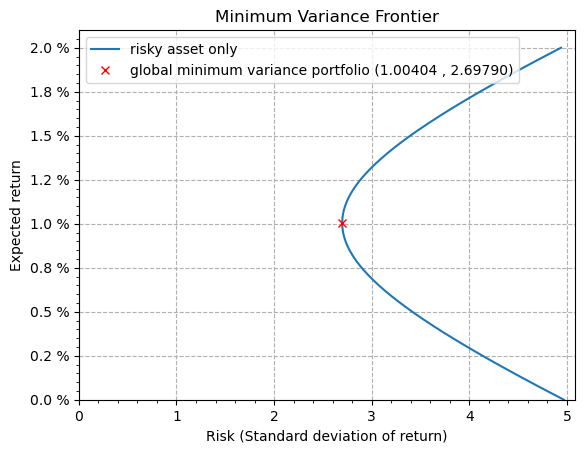

In [8]:
# plot the stuff
f1, ax1 = plt.subplots(1)
# f1.set_figheight(7)
# f1.set_figwidth(10)
ax1.plot(np.sqrt(var_list), possible_rp, label="risky asset only")
ax1.plot(
    np.sqrt(newmva.var_mva(newmva.R_mv)),
    newmva.R_mv,
    "rx",
    label=f"global minimum variance portfolio ({newmva.R_mv:.5f} , {np.sqrt(newmva.var_mva(newmva.R_mv)):.5f})",
)
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin=0)
ax1.set_xlabel("Risk (Standard deviation of return)")
ax1.set_ylabel("Expected return")
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.set_title("Minimum Variance Frontier")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax1.legend()
ax1.grid(linestyle="dashed")
plt.show(f1)
f1.savefig("f1.jpg")

In [9]:
# generate points - with risk free asset
rf = 0.13
var_list_riskfree = []
for x in possible_rp:
    var_list_riskfree.append(newmva.var_mva_with_riskfree(x, rf))

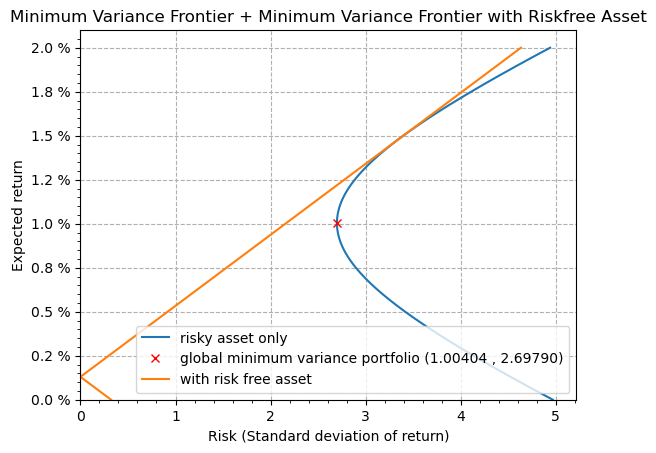

In [10]:
f2, ax2 = plt.subplots(1)
# f2.set_figheight(7)
# f2.set_figwidth(10)
ax2.plot(np.sqrt(var_list), possible_rp, label="risky asset only")
ax2.plot(
    np.sqrt(newmva.var_mva(newmva.R_mv)),
    newmva.R_mv,
    "rx",
    label=f"global minimum variance portfolio ({newmva.R_mv:.5f} , {np.sqrt(newmva.var_mva(newmva.R_mv)):.5f})",
)
ax2.plot(np.abs(np.sqrt(var_list_riskfree)), possible_rp, label="with risk free asset")
ax2.set_ylim(ymin=0)
ax2.set_xlim(xmin=0)
ax2.set_xlabel("Risk (Standard deviation of return)")
ax2.set_ylabel("Expected return")
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax2.set_title(
    "Minimum Variance Frontier + Minimum Variance Frontier with Riskfree Asset"
)
ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax2.legend()
ax2.grid(linestyle="dashed")
plt.show(f2)
f2.savefig("f2.jpg")

## Briefly explain the economic significance and relevance of the tangency portfolio to an investor.
 ##
* Tangency portfolio has the highest possible Sharpe ratio.

$$
R_{tg} = R_{mv} -\frac{\zeta\delta - \alpha^2}{\delta^2(R_f - R_{mv})}
$$
$$
\sigma_{tg} = -\frac{{(\zeta - 2\alpha R_f + \delta R_{f}^2)}^{0.5}}{\delta(R_f - R_{mv})}
$$

Risk premium for tangency is simply
$$
R_{tg} - R_{f}
$$

Note that Sharpe Ratio is
$$
\frac{R_p - R_f}{\sigma_p}
$$

* $R_p$ return of portfolio
* $R_f$ risk free rate
* $\sigma_p$  std dev of portfolio excess return

In [11]:
tangent_portfolio = newmva.tangent_portfolio(possible_rp, rf)
pd.DataFrame(
    [
        tangent_portfolio["return"],
        tangent_portfolio["var"],
        tangent_portfolio["std_dev"],
    ],
    index=["return", "var", "std_dev"],
    columns=["results"],
)

,results
return,1.486274
var,11.294481
std_dev,3.360726


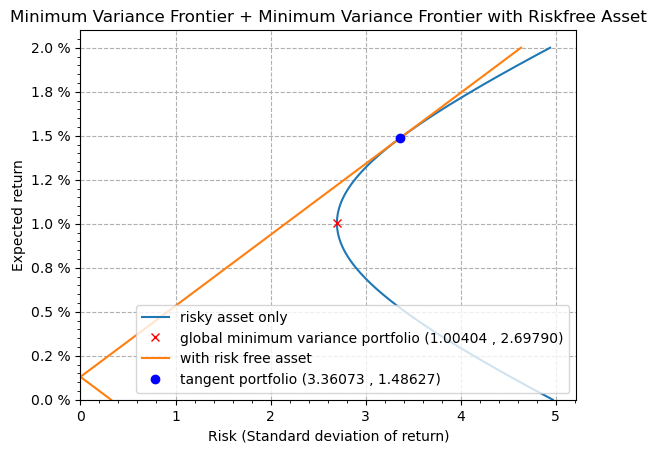

In [12]:
f3, ax3 = plt.subplots(1)
# f3.set_figheight(7)
# f3.set_figwidth(10)
ax3.plot(np.sqrt(var_list), possible_rp, label="risky asset only")
ax3.plot(
    np.sqrt(newmva.var_mva(newmva.R_mv)),
    newmva.R_mv,
    "rx",
    label=f"global minimum variance portfolio ({newmva.R_mv:.5f} , {np.sqrt(newmva.var_mva(newmva.R_mv)):.5f})",
)
ax3.plot(np.sqrt(var_list_riskfree), possible_rp, label="with risk free asset")
ax3.plot(
    tangent_portfolio["std_dev"],
    tangent_portfolio["return"],
    "bo",
    label=f"tangent portfolio ({tangent_portfolio['std_dev']:.5f} , {tangent_portfolio['return']:.5f})",
)
ax3.set_ylim(ymin=0)
ax3.set_xlim(xmin=0)
ax3.set_xlabel("Risk (Standard deviation of return)")
ax3.set_ylabel("Expected return")
ax3.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax3.set_title(
    "Minimum Variance Frontier + Minimum Variance Frontier with Riskfree Asset"
)
ax3.xaxis.set_major_locator(ticker.AutoLocator())
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.yaxis.set_major_locator(ticker.AutoLocator())
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax3.legend()
ax3.grid(linestyle="dashed")
plt.show(f3)
f3.savefig("f3.jpg")

In [13]:
tangent_portfolio_weights_df = pd.concat(
    [pd.Series(resultdf.index), pd.Series(tangent_portfolio["tangent_weights"])], axis=1
).rename(columns={0: "Industries", 1: "Weight"})

In [14]:
tangent_portfolio_weights_df

,Industries,Weight
0,NoDur,0.567972
1,Durbl,-0.214073
2,Manuf,0.714105
3,Enrgy,0.104087
4,HiTec,-0.363438
5,Telcm,-0.095463
6,Shops,0.991647
7,Hlth,0.075570
8,Utils,0.132643
9,Other,-0.913051
